# Projet 9 : Développez une preuve de concept

## Contexte

Vous essayez d'obtenir un poste de Data Scientist chez "DataSpace", une entreprise qui accompagne ses clients à concevoir et mettre en œuvre des solutions de data science, tant sur des données structurées que sur des problématiques de traitement d’image ou de texte.

Dans le cadre de votre recrutement, le recruteur aimerait que vous réalisiez une veille et que vous identifiez une méthode plus récente pour améliorer la performance d’un modèle.

J'ai choisi de m’inscrire dans une logique d'amélioration du travail réalisé lors du projet 8 de la formation IA Engineer, dans lequel j’ai implémenté la segmentation sémantique sur le dataset Cityscapes à l’aide d’un modèle U-Net, avec plusieurs variantes.

Ces premières expérimentations ont servi de méthode baseline. Les performances du modèle (mIoU, précision par classe, etc.) sur l’ensemble de validation Cityscapes me fourniront un point de comparaison fiable pour évaluer l’intérêt d’un modèle plus avancé.

Dans ce nouveau projet, je propose de mettre en oeuvre Mask2Former, une architecture récente basée sur des Transformers, dont la robustesse a été démontrée sur Cityscapes et dans des contextes dégradés (benchmark Cityscapes-Adverse, 2024).

L’objectif est de vérifier si ce modèle, plus complexe et mieux adapté aux scènes urbaines variées, apporte un gain significatif en performance et en robustesse.

Le projet prendra la forme d’une preuve de concept (PoC) :
- Je réaliserai une expérimentation contrôlée avec Mask2Former sur un sous-ensemble de Cityscapes,
- Je comparerai les résultats obtenus (visuellement et quantitativement) avec ceux de la baseline U-Net du projet 8, afin de valider l’intérêt du modèle avancé,
- Enfin, je présenterai la comparaison des résultats dans un dashboard Streamlit que je déploierai.

## Contenu des données du jeu de données Cityscapes :

2 dossiers **gtFine** et **leftImg8bit** contenant chacun les images séparés en données de train, val et test. Dans ces trois dossiers, les images sont divisées selon les différentes villes.

- **gtFine/** :

  **_gtFine_color.png* : contient les couleurs des classes de segmentation;
  
  **_gtFine_instanceIds.png* : contient les identifiants d'instance (objets de la même classe mais distincts : chacun a son numero d'instance unique);
  
  **_gtFine_labalIds.png* : contient les identifiants d'étiquette (chaque pixel contient son identifiant de classe);
  
  **_gtFine_polygons.json* : contient les formes des polygones (forme des objets);

- **leftImg8bit/** : les images brutes du jeu de données (photos de rue en RVB).


## Librairies utilisées avec le langage Python :

In [2]:
!pip install torch transformers==4.38.2 mlflow pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existi

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/P9')
os.environ['CUDA_LAUNCH_BLOCKING']="1"
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import gc
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from transformers import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torchvision.transforms import Resize, Normalize, ToTensor, Compose
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, f1_score
import shutil
import zipfile
import glob
from PIL import Image
from tqdm import tqdm
from itertools import product
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import subprocess
import mlflow
import mlflow.sklearn
import mlflow.tensorflow
import mlflow.pytorch
import mlflow.keras
from mlflow.tracking import MlflowClient
import threading
from pyngrok import ngrok
from pyngrok import conf
import time

In [4]:
# Lancement MLFlow
!fuser -k 5000/tcp #tue les processus du port 5000

local_path = "/content/drive/MyDrive/Colab_Notebooks/P9/mlruns"
os.makedirs(local_path,exist_ok=True)
mlflow.set_tracking_uri(f"file:{local_path}")
mlflow.set_experiment("P9")

<Experiment: artifact_location='file:///content/drive/MyDrive/Colab_Notebooks/P9/mlruns/583757542005292477', creation_time=1752227802408, experiment_id='583757542005292477', last_update_time=1752227802408, lifecycle_stage='active', name='P9', tags={}>

In [5]:
!lsof -i :5000

## Données image:

### Gestion locale

In [5]:
# Copier le zip en local
zip_path_in = '/content/drive/MyDrive/Colab_Notebooks/P9/Data.zip'
zip_path_out = '/content/Data.zip'
shutil.copy(zip_path_in, zip_path_out)

# Décompresser le zip
temp_path = '/content/temp'
os.makedirs(temp_path, exist_ok=True)
with zipfile.ZipFile(zip_path_out, 'r') as zip_ref:
  zip_ref.extractall(temp_path)

print(f'Fichier dézippé dans {temp_path}')


Fichier dézippé dans /content/temp


### Appariement des images et masques

In [6]:
# Liste d'images et de masques appairés pour le jeu de train
image_paths_train = sorted(glob.glob('/content/temp/Data/leftImg8bit/train/*/*.png',recursive=True))

images_list_train = []
masks_list_train = []

for img_path_train in image_paths_train:
    # Reconstituer le chemin du masque
    filename = os.path.basename(img_path_train)
    city = os.path.basename(os.path.dirname(img_path_train))

    mask_filename = filename.replace('leftImg8bit', 'gtFine_labelIds')

    # Construire le chemin complet vers le masque
    mask_path_train = os.path.join('/content/temp/Data/gtFine/train', city, mask_filename)

    if os.path.exists(mask_path_train):
        images_list_train.append(img_path_train)
        masks_list_train.append(mask_path_train)
    else:
        print(f"ATTENTION: Masque manquant pour {img_path_train}")

print(f"Total images train : {len(images_list_train)}")
print(f"Total masques train : {len(masks_list_train)}")

Total images train : 2975
Total masques train : 2975


In [7]:
# Liste d'images et de masques appairés pour le jeu de validation
image_paths_val = sorted(glob.glob('/content/temp/Data/leftImg8bit/val/*/*.png',recursive=True))

images_list_val = []
masks_list_val = []

for img_path_val in image_paths_val:
    # Reconstituer le chemin du masque
    filename = os.path.basename(img_path_val)
    city = os.path.basename(os.path.dirname(img_path_val))

    mask_filename = filename.replace('leftImg8bit', 'gtFine_labelIds')

    # Construire le chemin complet vers le masque
    mask_path_val = os.path.join('/content/temp/Data/gtFine/val', city, mask_filename)

    if os.path.exists(mask_path_val):
        images_list_val.append(img_path_val)
        masks_list_val.append(mask_path_val)
    else:
        print(f"ATTENTION: Masque manquant pour {img_path_val}")

print(f"Total images val : {len(images_list_val)}")
print(f"Total masques val : {len(masks_list_val)}")

Total images val : 500
Total masques val : 500


## Modèle Mask2Former

Papier de référence :

""Masked-attention Mask Transformer for Universal Image Segmentation"
Bowen Cheng, Ishan Misra, Alexander Kirillov, Rohit Girdhar, Alexander G. Schwing, 2022,  arXiv:2112.01527

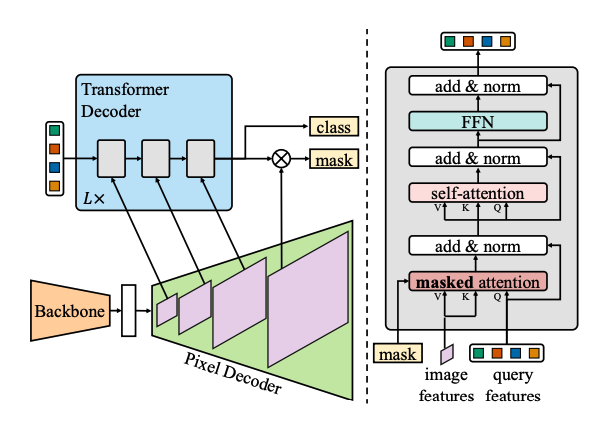

Mask2Former est basé sur une architecture Transformers et a été conçu pour la segmentation universelle (sémantique, instance et panoptique).

- Backbone (orange) :

Il s'agit d'un extracteur de caractéristiques standard, ici un Swin Transformer, pré-entrainé sur ImageNet-21k et fine-tuné pour la segmentation sémantique sur le dataset Cityscapes.

Les backbone de type Transformers sont plus lourds mais capturent mieux le contexte global et ont donc de meilleurs résultats.

- Pixel Decoder (vert) :

Le Pixel Decoder est un FPN (Feature Pyramid Network) qui fusionne les cartes de caractéristiques des différents étages du backbone 2 par 2 pour créer une pyramide de représentations multi-echelles empilées et pallier à la perte de la précision spatiale induite par les pooling du backbone.

- Transformer Decoder (bleu + exemple d'un blo à droite en gris)

Utilise tous les niveaux de la pyramide du Pixel Decoder en entrée.

Le Transformer Decoder est un transformer standard enrichi d'une masked cross-attention. Il sert à apprendre les requêtes (queries), initées aléatoirement, qui représentent des objets ou segments et leur associer une classe et un masque binaire indiquant la position de la requête à chacune.

Les requêtes partagent entre elles du contexte pour modéliser les relations entre elles (ex : query1 à coté de query5). Chacune va interroger les pixel des cartes de caractéristiques de Pixel Decoder mais seulement dans la zone du masque associé activée (appris lui aussi), grâce à la masked cross-attention, afin qu'elle se focalise spatialement.

Les requêtes passent par une couche de self-attention afin qu'elles partagent leurs informations et capturent leur dépendances/relations.

Le FFN (Feed Forward Network) est un traitement classique avec 2 couches linéaires (ou Dense) + une activation ReLU appliqué à chaque query indépendamment. Il permet de garder les informations importantes activés en ajoutant de la non-linéarité.

Ici, il y a 6 blocs dans le Transformer Decoder pour affiner progressivement la segmentation. Chaque bloc prend en compte toutes les requêtes mais sur un seul niveau de la pyramide du Pixel Decoder.

A la sortie, chaque requête produit un type de classe et un vecteur de masque qui sera multiplié (produit scalaire) avec la carte de caractéristique de plus haute résolution du Pixel Decoder pour former le masque final.

### Test du modèle pré-entrainé sur Cityscapes

In [9]:
# === FONCTIONS UTILITAIRES ===

def convert_to_train_id(mask):
  # Convertit les identifiants de classe Cityscapes en identifiants d'entraînement (trainId).
  # Entrée : masque avec identifiants Cityscapes (0 à 33).
  # Sortie : masque avec identifiants d'entraînement (0 à 18 ou 255 pour les pixels ignorés).
    label_to_trainid = {
        0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,
        7: 0, 8: 1, 9: 255, 10: 255, 11: 2, 12: 3, 13: 4,
        14: 255, 15: 255, 16: 255, 17: 5, 18: 255, 19: 6,
        20: 7, 21: 8, 22: 9, 23:10, 24:11, 25:12, 26:13,
        27:14, 28:15, 29:255, 30:255, 31:16, 32:17, 33:18
    }
    return np.vectorize(lambda x: label_to_trainid.get(x, 255))(mask).astype(np.uint8)

def map_19_to_8classes(mask):
  # Regroupe les 19 classes d'entraînement en 8 super-catégories.
  # Entrée : masque avec identifiants d'entraînement (0 à 18 ou 255).
  # Sortie : masque avec identifiants de super-catégorie (1 à 7 ou 255 pour les pixels ignorés).
    trainid_to_supercat = {
        255: 'vide',
        0: 'route/trottoir', 1: 'route/trottoir',
        2: 'construction', 3: 'construction', 4: 'construction',
        5: 'objet', 6: 'objet', 7: 'objet',
        8: 'nature', 9: 'nature',
        10: 'ciel',
        11: 'humain', 12: 'humain',
        13: 'vehicule', 14: 'vehicule', 15: 'vehicule',
        16: 'vehicule', 17: 'vehicule', 18: 'vehicule'
    }

    supercat_to_id = {
        'vide': 255,  # Important : 255 pour ignorer dans les métriques
        'route/trottoir': 1,
        'construction': 2,
        'objet': 3,
        'nature': 4,
        'ciel': 5,
        'humain': 6,
        'vehicule': 7
    }

    return np.vectorize(lambda x: supercat_to_id[trainid_to_supercat.get(x, 'vide')])(mask).astype(np.uint8)

def get_distinct_palette(num_classes=8):
  # Génère une palette de couleurs distinctes pour visualiser les classes de segmentation.
  # Utilise le colormap 'tab20' de matplotlib pour garantir des couleurs bien différenciées.
  # Entrée : nombre de classes (par défaut 8).
  # Sortie : tableau numpy de couleurs RGB pour chaque classe.
    cmap = plt.get_cmap('tab20', num_classes - 1)
    palette = np.zeros((num_classes, 3), dtype=np.uint8)
    for i in range(1, num_classes):
        r, g, b = cmap(i - 1)[:3]
        palette[i] = [int(r * 255), int(g * 255), int(b * 255)]
    return palette

PALETTE = get_distinct_palette()

def decode_mask(mask, palette=PALETTE):
  # Convertit un masque de classes (entiers) en image RGB en utilisant une palette de couleurs.
  # Chaque pixel est coloré selon sa classe, les pixels ignorés (255) sont rendus en noir.
  # Entrée : masque de classes (valeurs entières).
  # Sortie : image PIL colorée représentant le masque.
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(len(palette)):
        color_mask[mask == cls_id] = palette[cls_id]
    color_mask[mask == 255] = [0, 0, 0]  # Ignorés en noir
    return Image.fromarray(color_mask)

def create_overlay(image_pil, mask_pil, alpha=0.5):
  # Crée une image de superposition entre l'image originale et le masque coloré.
  # Permet de visualiser la segmentation en transparence sur l'image source.
  # Entrée : image PIL originale, image PIL du masque, alpha (transparence).
  # Sortie : image PIL fusionnée.
    image_np = np.array(image_pil.convert("RGB")).astype(np.uint8)
    mask_np = np.array(mask_pil.convert("RGB")).astype(np.uint8)
    overlay_np = (alpha * image_np + (1 - alpha) * mask_np).astype(np.uint8)
    return Image.fromarray(overlay_np)


In [10]:
# === TEST D'INFERENCE MASK2FORMER ===
# Chargement du modèle pré-entraîné sur Cityscapes via HuggingFace.
model_name = "facebook/mask2former-swin-small-cityscapes-semantic"
processor = AutoImageProcessor.from_pretrained(model_name)
model = Mask2FormerForUniversalSegmentation.from_pretrained(model_name, output_attentions=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Modèle mis en mode évaluation
model.to(device).eval()

# Dossier de sortie où seront enregistrés les images, masques et overlays générés
output_dir = "/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former"
os.makedirs(output_dir, exist_ok=True)

# Boucle d'inférence
global_cm = np.zeros((8, 8), dtype=np.int64)

with mlflow.start_run(run_name="Mask2Former"):

    for idx, (img_path, mask_path) in enumerate(tqdm(zip(images_list_val, masks_list_val), total=len(images_list_val))):
        # Ouverture des images et masques
        image = Image.open(img_path).convert("RGB")
        mask = np.array(Image.open(mask_path))

        # Remapping des masques réels
        gt_mask = convert_to_train_id(mask)
        gt_mask = map_19_to_8classes(gt_mask)

        #  Pré-traitement des images par le processor de Mask2Former
        inputs = processor(images=image, return_tensors="pt").to(device)

        # Prédiction
        with torch.no_grad():
            outputs = model(**inputs)

        all_attentions = outputs.attentions

        name = os.path.splitext(os.path.basename(img_path))[0]
        save_path = os.path.join(output_dir,f"attention_{name}.pt")
        torch.save(all_attentions, save_path)

        # Remapping des masques prédits
        pred_mask = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0].cpu().numpy()
        pred_mask = map_19_to_8classes(pred_mask)

        # Filtrage des pixels ignorés pour les métriques
        valid = gt_mask.flatten() != 255
        gt_valid = gt_mask.flatten()[valid]
        pred_valid = pred_mask.flatten()[valid]

        # Calcul de la matrice de confusion
        cm = confusion_matrix(gt_valid, pred_valid, labels=list(range(8)))
        global_cm += cm

        # Génération des visualisations
        pred_mask[gt_mask == 255] = 255 # Forcer les pixels ignorés du masque réel à l'être également dans le masque prédit
        pred_vis = decode_mask(pred_mask)
        gt_vis = decode_mask(gt_mask)
        overlay = create_overlay(image, pred_vis)

        # Enregistrement des visualisations
        image.save(os.path.join(output_dir, f"img_{name}.png"))
        pred_vis.save(os.path.join(output_dir, f"pred_{name}.png"))
        gt_vis.save(os.path.join(output_dir, f"gt_{name}.png"))
        overlay.save(os.path.join(output_dir, f"overlay_{name}.png"))

    # Calcul des métriques à partir de la matrice de confusion
    TP = np.diag(global_cm)
    FP = global_cm.sum(axis=0) - TP
    FN = global_cm.sum(axis=1) - TP

    denom = TP + FP + FN
    iou_per_class = np.divide(TP, denom, out=np.zeros_like(TP, dtype=float), where=denom != 0)
    mean_iou = np.mean(iou_per_class)
    weighted_iou = np.sum(iou_per_class * global_cm.sum(axis=1)) / global_cm.sum()

    precision = np.divide(TP, TP + FP, out=np.zeros_like(TP, dtype=float), where=(TP + FP) != 0)
    recall = np.divide(TP, TP + FN, out=np.zeros_like(TP, dtype=float), where=(TP + FN) != 0)
    dice_per_class = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(TP, dtype=float), where=(precision + recall) != 0)

    support = global_cm.sum(axis=1)
    dice_macro = dice_per_class.mean()
    dice_weighted = np.sum(dice_per_class * support) / support.sum()
    dice_global = 2 * TP.sum() / (2 * TP.sum() + FP.sum() + FN.sum())

    # Log  des métriques dans MLflow
    for i in range(8):
        mlflow.log_metric(f"iou_class_{i}", iou_per_class[i])
        mlflow.log_metric(f"dice_class_{i}", dice_per_class[i])
    mlflow.log_metric("mean_iou_macro", mean_iou)
    mlflow.log_metric("mean_iou_weighted", weighted_iou)
    mlflow.log_metric("dice_macro", dice_macro)
    mlflow.log_metric("dice_weighted", dice_weighted)
    mlflow.log_metric("dice_global", dice_global)

    # Visualisation et sauvegarde de la matrice de confusion dans MLflow
    plt.figure(figsize=(8, 6))
    sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
    plt.xlabel("Prédictions")
    plt.ylabel("Réels")
    plt.title("Matrice de confusion Mask2Former (pixels valides uniquement)")
    conf_path = os.path.join(output_dir, "conf_matrix_mask2former.png")
    plt.savefig(conf_path)
    mlflow.log_artifact(conf_path)
    plt.close()

print("✅ Terminé : métriques loggées, visuels enregistrés.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/275M [00:00<?, ?B/s]

100%|██████████| 500/500 [2:02:36<00:00, 14.71s/it]


✅ Terminé : métriques loggées, visuels enregistrés.


Le modèle Mask2Former ne prédit pas la classe vide, il est donc difficile de comparer ces résultats avec ceux du projet 8.

La seule option est de comparer les métriques par classe, en sachant que pour Mask2Former, celles de la classe 0 seront à 0.
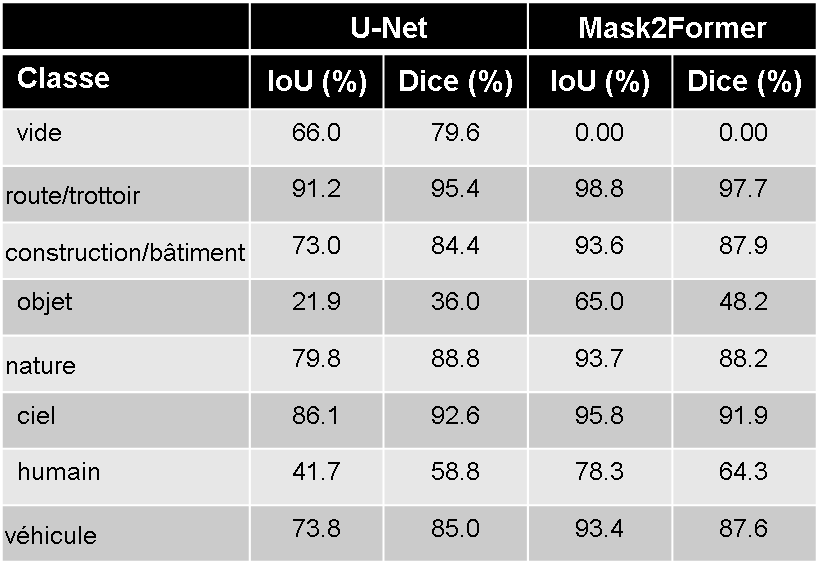

On peut tout de suite voir que, excepté pour la classe 0 qui correspond au vide, toutes les métriques par classe sont largement meilleures avec Mask2Former.

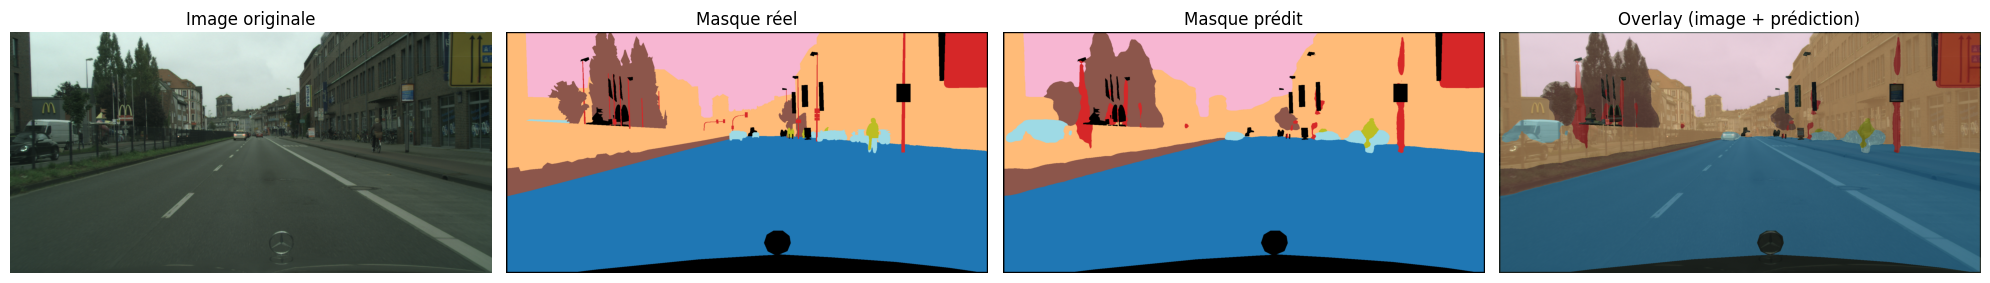

In [11]:
# Affichage d'un exemple
image = Image.open("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/img_munster_000004_000019_leftImg8bit.png").convert("RGB")
gt_mask = Image.open("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/gt_munster_000004_000019_leftImg8bit.png")
pred_mask = Image.open("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/pred_munster_000004_000019_leftImg8bit.png")
overlay = Image.open("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/overlay_munster_000004_000019_leftImg8bit.png")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(image)
axs[0].set_title("Image originale")
axs[1].imshow(gt_mask)
axs[1].set_title("Masque réel")
axs[2].imshow(pred_mask)
axs[2].set_title("Masque prédit")
axs[3].imshow(overlay)
axs[3].set_title("Overlay (image + prédiction)")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

La visualisation du masque prédit confirme bien que le modèle Mask2Former a de meilleurs résultats que le modèle U-net du projet 8, en particulier sur les objets fins et les classes rares.


#### Importance globale

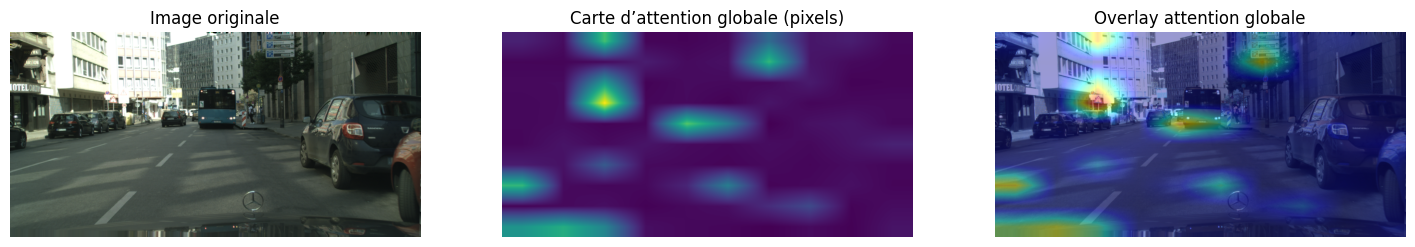

In [5]:
def compute_global_attention_mask2former(img_np, all_attentions):
    att_maps = []

    for layer_att in all_attentions:  # chaque couche
        # [B, heads, Nq, Nk]
        att_mean = layer_att.mean(1)   # moyenne sur les têtes → [B, Nq, Nk]
        att_mean = att_mean.mean(1)    # moyenne sur les requêtes → [B, Nk]
        att_map = att_mean[0]          # batch 0
        att_maps.append(att_map.cpu())

    # moyenne sur toutes les couches
    att_global = torch.stack(att_maps).mean(0)  # [Nk]

    # reshape selon la taille du backbone (dernière feature map)
    H = W = int(att_global.shape[0] ** 0.5)  # supposer carré
    att_map = att_global.reshape(H, W).numpy()
    att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min())

    # resize à la taille image
    att_resized = cv2.resize(att_map, (img_np.shape[1], img_np.shape[0]))
    att_uint8 = (att_resized * 255).astype(np.uint8)

    # heatmap et overlay
    heatmap = cv2.applyColorMap(att_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    return att_resized, heatmap, overlay


# --- Visualisation ---
image = Image.open("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/img_frankfurt_000000_013382_leftImg8bit.png").convert("RGB")
img_np = np.array(image)
attentions = torch.load("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/attention_frankfurt_000000_013382_leftImg8bit.pt")
att_map, heatmap, overlay = compute_global_attention_mask2former(img_np, attentions)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img_np)
axes[0].set_title("Image originale")
axes[0].axis("off")

axes[1].imshow(att_map, cmap="viridis")
axes[1].set_title("Carte d’attention globale (pixels)")
axes[1].axis("off")

axes[2].imshow(overlay[..., ::-1])  # BGR → RGB
axes[2].set_title("Overlay attention globale")
axes[2].axis("off")

plt.show()

L’overlay montre que le modèle consacre beaucoup d’attention à des régions sémantiquement importantes pour la scène urbaine (voies de circulation, obstacles, panneaux).

Mask2Former apprend des requêtes qui se spécialisent dans des objets ou régions. Ici, les zones d’attention suggèrent que le modèle hiérarchise les objets dominants (bus, façades, panneaux, route centrale) et néglige volontairement les zones peu pertinentes (ciel, zones très sombres).

Limites visibles :
On observe encore une dispersion de l’attention sur certaines zones de la chaussée (patchs bleus/verts à gauche et bas). Cela peut refléter une incertitude du modèle dans des zones visuellement homogènes (asphalte).

#### Importance locale

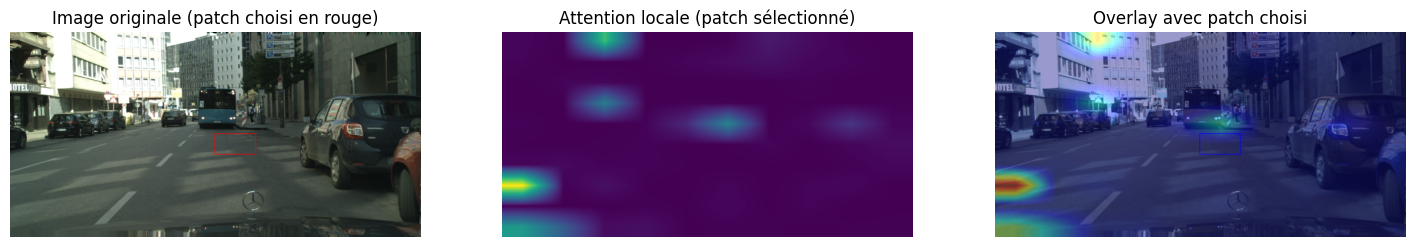

In [8]:
def compute_local_attention_mask2former(img_np, all_attentions, patch_coords=None, layer_idx=-1, head_idx=None, coords_in_pixels=False):
    """
    Analyse locale avec choix d'une couche et d'une tête.
    - patch_coords : (y, x) du patch choisi.
        -> si coords_in_pixels=True, ce sont des coordonnées pixels de l'image
        -> sinon ce sont des indices de patchs (dans la grille H×W)
    """
    layer_att = all_attentions[layer_idx]   # [B, heads, Nq, Nk]

    if head_idx is None:
        att_mean = layer_att.mean(1)        # moyenne sur les têtes → [B, Nq, Nk]
    else:
        att_mean = layer_att[:, head_idx]   # tête spécifique → [B, Nq, Nk]

    att_mean = att_mean[0]                  # batch 0

    # dimensions spatiales de la grille
    H = W = int(att_mean.shape[-1] ** 0.5)

    # choix du patch
    if patch_coords is None:
        py, px = H // 2, W // 2            # patch central
    else:
        if coords_in_pixels:  # conversion coordonnées pixels → indices de patch
            patch_h = img_np.shape[0] // H
            patch_w = img_np.shape[1] // W
            py = patch_coords[0] // patch_h
            px = patch_coords[1] // patch_w
        else:
            py, px = patch_coords

    q_idx = py * W + px

    # vecteur d’attention pour ce patch
    att_vec = att_mean[q_idx]               # [Nk]
    att_map = (att_vec - att_vec.min()) / (att_vec.max() - att_vec.min())
    att_map = att_map.reshape(H, W).cpu().numpy()

    # resize à la taille de l'image
    att_resized = cv2.resize(att_map, (img_np.shape[1], img_np.shape[0]))
    att_uint8 = (att_resized * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(att_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # tracer le rectangle du patch sélectionné
    patch_h = img_np.shape[0] // H
    patch_w = img_np.shape[1] // W
    x1, y1 = px * patch_w, py * patch_h
    x2, y2 = x1 + patch_w, y1 + patch_h

    img_marked = img_np.copy()
    overlay_marked = overlay.copy()
    cv2.rectangle(img_marked, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.rectangle(overlay_marked, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return att_resized, heatmap, overlay_marked, img_marked

# --- Visualisation ---
image = Image.open("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/img_frankfurt_000000_013382_leftImg8bit.png").convert("RGB")
img_np = np.array(image)
attentions = torch.load("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/attention_frankfurt_000000_013382_leftImg8bit.pt")

# patch central
att_local, heatmap, overlay, img_marked= compute_local_attention_mask2former(img_np, attentions, layer_idx=2, head_idx=0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img_marked)
axes[0].set_title("Image originale (patch choisi en rouge)")
axes[0].axis("off")

axes[1].imshow(att_local, cmap="viridis")
axes[1].set_title("Attention locale (patch sélectionné)")
axes[1].axis("off")

axes[2].imshow(overlay[..., ::-1])  # BGR → RGB
axes[2].set_title("Overlay avec patch choisi")
axes[2].axis("off")
plt.show()

Ce patch central correspond à la zone inférieure du bus, proche de la route.

On observe que ce patch active surtout la zone du bus lui-même et quelques zones de la route et des bâtiments à gauche. Cela suggère que la tête associe cette zone du bus non seulement au bus mais aussi à son contexte urbain (route, immeuble).

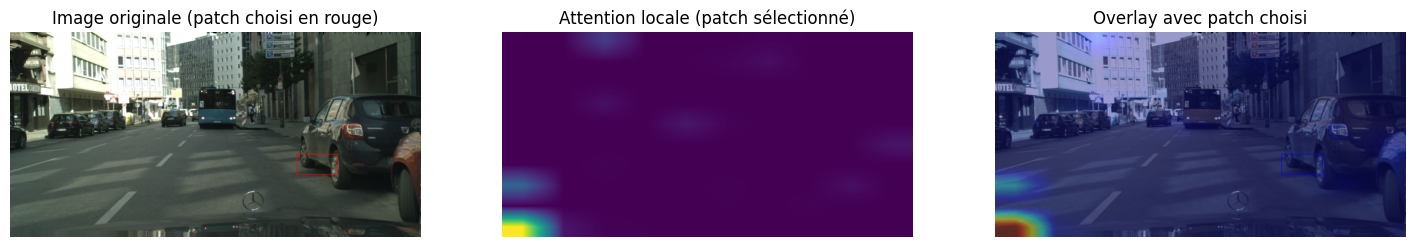

In [9]:
# --- Visualisation ---
image = Image.open("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/img_frankfurt_000000_013382_leftImg8bit.png").convert("RGB")
img_np = np.array(image)
attentions = torch.load("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/attention_frankfurt_000000_013382_leftImg8bit.pt")

# patch central
att_local, heatmap, overlay, img_marked = compute_local_attention_mask2former(img_np, attentions, patch_coords=(6,7), layer_idx=2, head_idx=0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img_marked)
axes[0].set_title("Image originale (patch choisi en rouge)")
axes[0].axis("off")

axes[1].imshow(att_local, cmap="viridis")
axes[1].set_title("Attention locale (patch sélectionné)")
axes[1].axis("off")

axes[2].imshow(overlay[..., ::-1])  # BGR → RGB
axes[2].set_title("Overlay avec patch choisi")
axes[2].axis("off")
plt.show()


Sur cette même tête, mais avec un autre patch (sur la voiture garée à droite), l’attention se déporte très fortement sur le coin inférieur gauche de l’image correspondant à de la route. Il y a peu d’activation sur la voiture elle-même.

Certaines têtes d’attention se spécialisent. Peut être que celle-ci ne capture pas des relations spatiales locales, mais plutôt des relations globales contextuelles.

C’est la force des Transformers : certaines têtes apprennent le focus local et d’autres apprennent des relations globales.

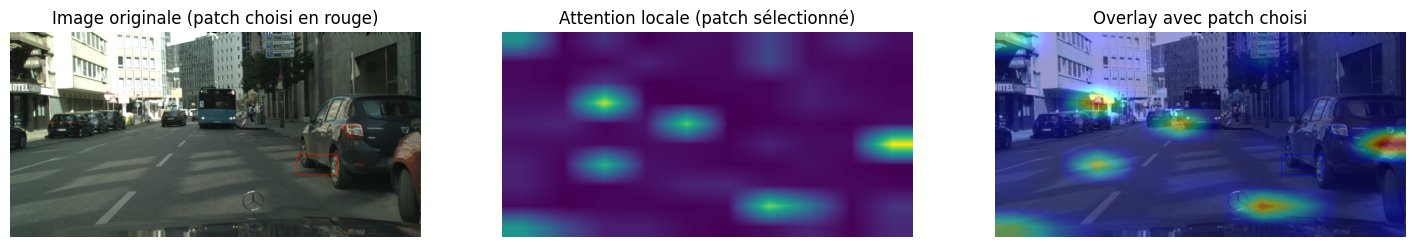

In [15]:
# --- Visualisation ---
image = Image.open("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/img_frankfurt_000000_013382_leftImg8bit.png").convert("RGB")
img_np = np.array(image)
attentions = torch.load("/content/drive/MyDrive/Colab_Notebooks/P9/outputs_mask2former/attention_frankfurt_000000_013382_leftImg8bit.pt")

# patch central
att_local, heatmap, overlay, img_marked = compute_local_attention_mask2former(img_np, attentions, patch_coords=(6,7), layer_idx=2, head_idx=7)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img_marked)
axes[0].set_title("Image originale (patch choisi en rouge)")
axes[0].axis("off")

axes[1].imshow(att_local, cmap="viridis")
axes[1].set_title("Attention locale (patch sélectionné)")
axes[1].axis("off")

axes[2].imshow(overlay[..., ::-1])  # BGR → RGB
axes[2].set_title("Overlay avec patch choisi")
axes[2].axis("off")
plt.show()

Si l'on garde ce patch situé sur la voiture garée à droite mais que l'on regarde une autre tête, ici l’attention se disperse sur plusieurs zones d’intérêt distinctes :
- sur la voiture à droite,
- sur le bus central,
- sur des zones de la route et des immeubles à gauche.

Cette tête semble connecter la voiture à des éléments centraux de la scène (bus, route, immeuble). Le modèle apprend que la voiture garée fait partie d’une scène routière globale et l’associe au bus et à l’environnement urbain.

In [ ]:
ngrok.kill()
# https://dashboard.ngrok.com/agents    pour kill les sessions ngrok en cours

# Authentifier avec ton token
ngrok.set_auth_token("2waHSDEITs7Xn3gcB3stogIL4Ho_795MuQhFYDULrxjMPzNBJ")

mlflow_process = subprocess.Popen(
    ["mlflow", "ui", "--port", "5000" , "--backend-store-uri", "file:///content/drive/MyDrive/Colab_Notebooks/P9/mlruns"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

def print_stdout(proc):
    for line in proc.stdout:
        print("[MLFLOW STDOUT]", line.decode(), end="")

def print_stderr(proc):
    for line in proc.stderr:
        print("[MLFLOW STDERR]", line.decode(), end="")

threading.Thread(target=print_stdout, args=(mlflow_process,), daemon=True).start()
threading.Thread(target=print_stderr, args=(mlflow_process,), daemon=True).start()


# Tunnel avec ngrok vers ce port
time.sleep(5)  # Laisse le temps à mlflow de se lancer
public_url = ngrok.connect(5000)
print(f"MLflow UI est accessible ici : {public_url}")